# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)

In [ ]:
# Мы должны убедиться, что GPU включен в notebook
# сообщение, которое мы хотим увидеть: CUDA is available!  Training on GPU ...
# 
# если мы получили обратное сообщение, то нужно включить GPU:
# из Меню > Среда выполнения > сменить среду выполнения > Аппаратный ускоритель > GPU

import torch
import torch.nn as nn
import albumentations as A
from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader 

import numpy as np
import PIL
import pickle
from PIL import Image
from skimage import io
from tqdm import tqdm, tqdm_notebook
from pathlib import Path

from matplotlib import colors, pyplot as plt
%matplotlib inline


# в sklaern не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not abailable. Training on CPU ...')
else:
  print('CUDA is available. Training on GPU ...')

CUDA is available. Training on GPU ...


In [ ]:
!nvidia-smi
torch.cuda.is_available()

Tue Jul 26 07:36:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
from torchvision.transforms.transforms import ToTensor
class SimpsonsDataset(Dataset):
  """
  Датасет с картинками, который параллельно подгружает их из папок
  производит скалирование и превращение в торчевые тензоры
  """
  def __init__(self, files, mode, full_transform):
    super().__init__()
    # список файлов для загрузки
    self.files = sorted(files)
    # режим работы
    self.mode = mode
    # режим трансформации данных
    self.full_transform = full_transform

    if self.mode not in DATA_MODES:
      print(f'{self.mode} is not correct; correct modes: {DATA_MODES}')
      raise NameError

    self.len_ = len(self.files)

    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump_file:
        pickle.dump(self.label_encoder, le_dump_file)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
      # для преобразования изображений в тензоры PyTorch и нормализации входа
      if self.full_transform:
        if self.mode == 'train':
          transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.RandomResizedCrop(RESCALE_SIZE-32),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        if self.mode == 'val':
          transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),                             
            transforms.CenterCrop(RESCALE_SIZE-32),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
          ])
        if self.mode == 'test':
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
          ])
      if self.full_transform is False:
        if self.mode == 'train':
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        if self.mode == 'val':
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
          ])
        if self.mode == 'test':
          transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
          ])
      x = self.load_sample(self.files[index])
      if self.full_transform:
        x = transform(x)
      if self.full_transform is False:
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
      if self.mode == 'test':
          return x
      else:
          label = self.labels[index]
          label_id = self.label_encoder.transform([label])
          y = label_id.item()
          return x, y

  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip /content/gdrive/MyDrive/'journey-springfield (3)'.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pi

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split


train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [ ]:
data = np.unique(train_val_labels, return_counts=True)
data_list = []
"""
[
 {'abraham': {'predicted': 1,
              'true': 913}
  },
  ...

]
"""
for key, values in zip(data[0], data[1]):
  character = {key: {'true_amount': values, 
                     'predicted': 0}}
  data_list.append(character)

coder_dict = {id: key for id, key in enumerate(np.unique(data[0]))} # кодируем имена героев в числа

def get_predicted(preds):
  for pred in preds:
    for statistics in data_list[pred].values():
      statistics['predicted'] += 1

## Проведем Анализ данных

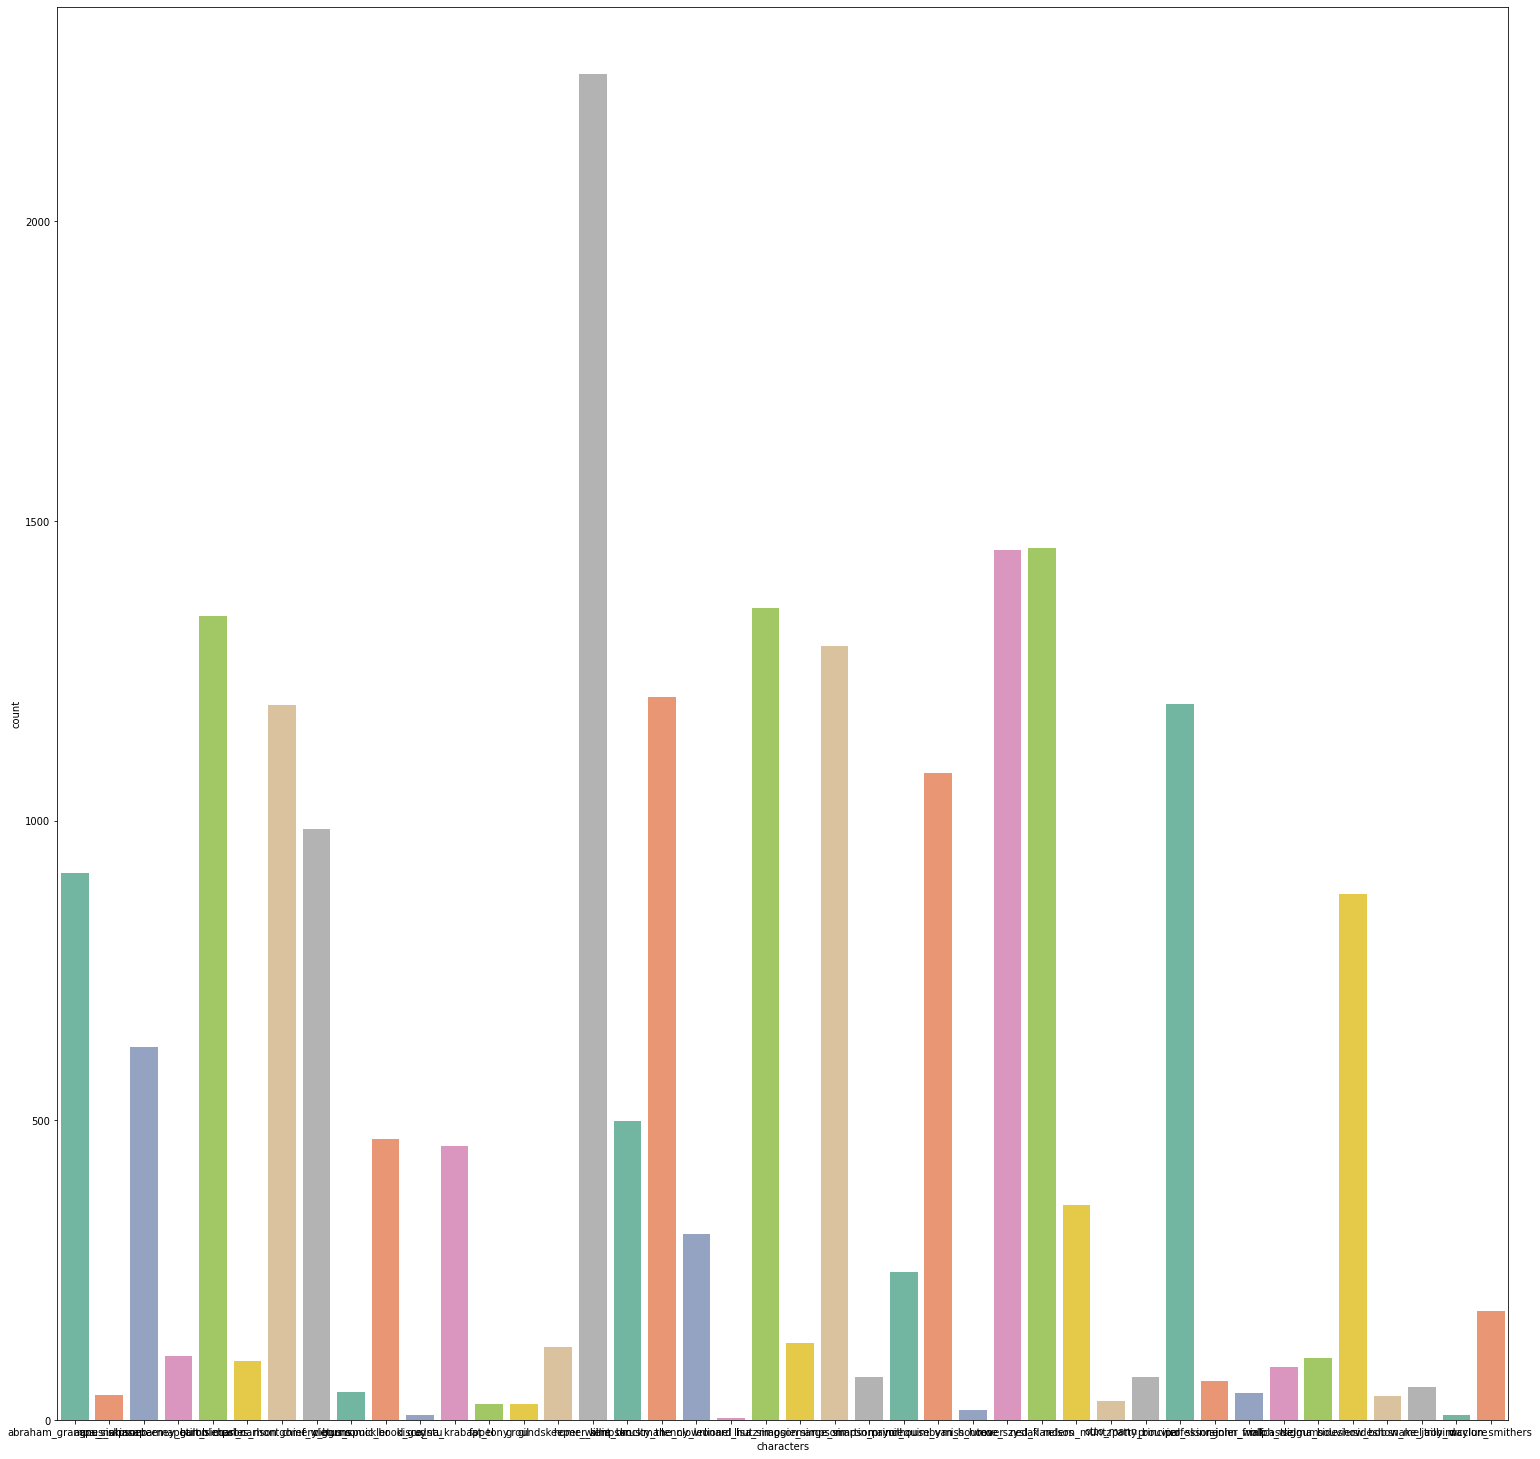

Всего классов: 42
Всего объектов обучающей выборки: 20933
герой: abraham_grampa_simpson кол-во объектов: 913 процент от всего набора данных: 4.36%
герой: agnes_skinner кол-во объектов: 42 процент от всего набора данных: 0.201%
герой: apu_nahasapeemapetilon кол-во объектов: 623 процент от всего набора данных: 2.98%
герой: barney_gumble кол-во объектов: 106 процент от всего набора данных: 0.506%
герой: bart_simpson кол-во объектов: 1342 процент от всего набора данных: 6.41%
герой: carl_carlson кол-во объектов: 98 процент от всего набора данных: 0.468%
герой: charles_montgomery_burns кол-во объектов: 1193 процент от всего набора данных: 5.7%
герой: chief_wiggum кол-во объектов: 986 процент от всего набора данных: 4.71%
герой: cletus_spuckler кол-во объектов: 47 процент от всего набора данных: 0.225%
герой: comic_book_guy кол-во объектов: 469 процент от всего набора данных: 2.24%
герой: disco_stu кол-во объектов: 8 процент от всего набора данных: 0.0382%
герой: edna_krabappel кол-во объект

In [ ]:
from collections import Counter
import pandas as pd
import seaborn as sns


data_counter = Counter(train_val_labels)
data_dict = {'characters' : train_val_labels}
data_dict = {'' + str(i): characters for characters, i in zip(data_dict['characters'], 
                                                              range(len(data_dict['characters'])))}
data = pd.DataFrame(list(data_dict.values()), columns=['characters'])

plt.figure(figsize=(26, 26))
sns.countplot(data=data, x='characters', palette='Set2')
plt.show()

print(f'Всего классов: {len(np.unique(train_val_labels))}')
num_train_object = len(train_val_labels)
print(f'Всего объектов обучающей выборки: {num_train_object}')
data_procent = {character: [value/num_train_object, value] for character, value in data_counter.items()}
for character, value in data_procent.items():
  print(f'герой: {character} кол-во объектов: {value[1]} процент от всего набора данных: {value[0]*100:.3}%')

42 героя у нас в датасете, у каждого героя разное количество картинок.<br>
Классы получились несбалансированными, у кого-то 1454 картинок, а у кого-то всего 3. <br>
Из-за этого класс с меньшими картинками имеет меньший шанс быть предсказаным. <br>
Проблему с дисбалансом мы решим после проверки дефолтной cnn.

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val', full_transform=False)

In [ ]:
def register_extension(id, extension): 
  Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

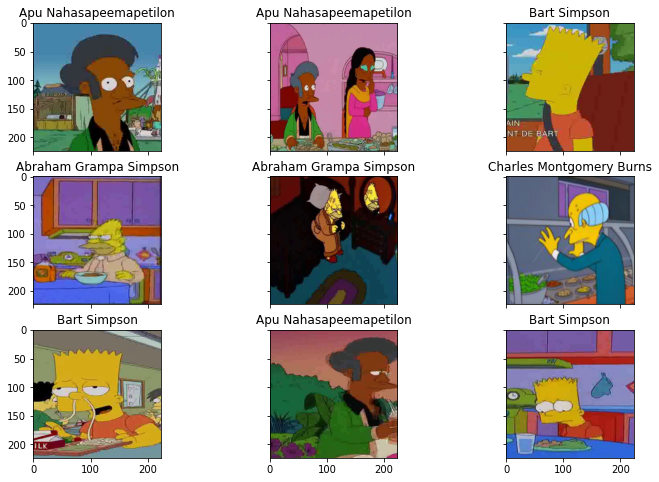

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 8), 
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(),
          title=img_label,plt_ax=fig_x)

### Построение нейросети


In [ ]:
class SimpleCnn(nn.Module):
  def __init__(self, n_classes, full_transform):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.full_transform = full_transform
    if self.full_transform:
      self.out = nn.Linear(96 * 4 * 4, n_classes)
    if self.full_transform == False:
      self.out = nn.Linear(96 * 5 * 5, n_classes)
    #self.full_transform = full_transform
    #self.n_classes = n_classes

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    #if self.full_transform:
      #vector_shape = x.shape[1] * x.shape[2] * x.shape[3]
      #print(vector_shape)
      #self.out = nn.Linear(96 * 4 * 4, 42)  
    x = x.view(x.size(0), -1)
    logits = self.out(x)
    return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, epoch_last, scheduler):
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0
  scheduler.step()

  for inputs, labels in tqdm_notebook(train_loader):
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(outputs, 1)
    if epoch_last:
      get_predicted(preds) # добавляем к классу одно предсказание
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = running_loss / processed_data
  train_acc = running_corrects.cpu().numpy() / processed_data
  return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion, epoch_last, scheduler):
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  processed_size = 0
  scheduler.step()

  for inputs, labels in val_loader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)
      if epoch_last:
        get_predicted(preds) # добавляем к классу одно предсказание
    
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_size += inputs.size(0)
  val_loss = running_loss / processed_size
  val_acc = running_corrects.double() / processed_size
  return val_loss, val_acc  

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, sampler=None, freeze=False):
  if sampler is not None:
    shuffle_flag=False
  else:
    shuffle_flag=True
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_flag, sampler=sampler)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  history = []
  log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
  
  with tqdm(desc='epoch', total=epochs) as pbar_outer:
    if freeze == True:
      opt = torch.optim.Adam(list(model.features[:-layers_to_unfreeze].parameters()) +
                             list(model.classifier.parameters()), lr=0.001)
    if freeze == False:  
      opt = torch.optim.Adam(model.parameters(), lr=0.001)
    if freeze == 'ResNet':
      opt = torch.optim.Adam(list(model.layer4.parameters()) + list(model.fc.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

    for epoch in range(epochs):
      if epoch == epochs-1:
        epoch_last = True
      else:
        epoch_last = False
      train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, epoch_last, exp_lr_scheduler)
      print('loss', train_loss)

      val_loss, val_acc = eval_epoch(model, val_loader, criterion, epoch_last, exp_lr_scheduler)
      history.append((train_loss, train_acc, val_loss, val_acc))

      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
  return history


In [ ]:
def predict(model, test_loader):
  with torch.no_grad():
    logits = []

    for inputs in test_loader:
      inputs = inputs.to(DEVICE)
      model.eval()
      outputs = model(inputs).cpu()
      logits.append(outputs)

  probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
  return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes, full_transform=False).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

##Обучение сети

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val', full_transform=False)

train_dataset = SimpsonsDataset(train_files, mode='train', full_transform=False)

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/246 [00:00<?, ?it/s]

Посмотрим сколько раз каждый класс был предсказан

In [ ]:
data_list

Видно, что классы с меньшим количеством картинок были плохо предсказаны, где-то по нулям

Построим кривую обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

Здесь можно сказать, что явно не хватает эпох, так как прямые еще стремятся к уменьшению 

## Работа с предсказаниями

Реализуем предсказание для одной картинки

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
  """ Предсказание для одной картинки """
  with torch.no_grad():
    inputs = inputs.to(DEVICE)
    model.eval()
    logit = model(inputs).cpu()
    probs = torch.nn.functional.softmax(logit, dim=-1)
  return probs

In [ ]:
label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

In [ ]:
random_characters = int(np.random.uniform(0, len(val_dataset)))
ex_img, true_label = val_dataset[random_characters]
probs_img = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))
imshow(ex_img.data.cpu())

pred = torch.argmax(probs_img, 1)

true_label_name = label_encoder.classes_[true_label]
predict_name = label_encoder.classes_[pred]

print(f'True label = {true_label}')
print(f'True label name = {true_label_name}')
print(f'Predict = {pred.item()}')
print(f'Predict name = {predict_name}')

Реализуем предсказание для 20 картинок

In [ ]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_imgs = predict(simple_cnn, imgs)

In [ ]:
y_pred = np.argmax(probs_imgs, -1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_labels, y_pred

Посмотрим на f1 score

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

Визуализируем уверенность сети в своих предсказаниях

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred.numpy())*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=14, color='black',fontweight='bold')

Оценка f1 простой cnn показала <b>0.55</b> <br>
<b>SimpleCNN:</b> <br>
-optimizer = Adam<br>
-learning rate = 0.001<br>
-sheduler = dont use [x]<br>
-bath size = 64<br>
-epochs = 2<br>
-criterion = nn.CrossEntropyLoss()<br>
-Data Augmentation = dont use [x]<br>
-Дисбаланс классов




## Решим проблему с дисбалансом классов

Метод основан на вероятности появления каждого класса.<br>
Например, класс ned_flanders встречается 1454 раза, а класс lionel_hutz всего 3 раза. Понятно, что lionel_hurtz попросту не будет распознаваться, нужно сделать так, чтобы он появлялся в батчах чаще чем, ned_flanders.<br>
<b>p - вероятность, n - кол-во картинок</b> <br>
$p(ned flanders) = \frac{1}{n} = 0.00068776$ <br>
$p(lionelhurtz) = \frac{1}{n} = 0.033$ <br>

In [ ]:
class_sample_count = np.unique(train_val_labels, return_counts=True)[1]
class_sample_count # сколько раз встречается каждый класс

In [ ]:
data = [path.parent.name for path in train_files]
coder_dict = {key: id for id, key in enumerate(np.unique(data))} # кодируем имена героев в числа
for index, character in enumerate(data): # заменяем имена на числа
  data[index] = coder_dict[character]


weight = 1. / class_sample_count # считаем вес каждого класса 1 / кол-во картинок
samples_weight = weight[data] 
samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight)) # создаем sampler для dataloader

## Тестируем модель после попытки установить баланс классов

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val', full_transform=True)

train_dataset = SimpsonsDataset(train_files, mode='train', full_transform=True)

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes, full_transform=True).to(DEVICE)
print("we will classify :{}".format(n_classes))
#img, label = train_dataset[2078]
#simple_cnn(img.unsqueeze(0))

In [ ]:
BATCH_SIZE = 128
history2 = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=BATCH_SIZE, sampler=sampler)

In [ ]:
data_list

In [ ]:
loss, acc, val_loss, val_acc = zip(*history2)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_imgs = predict(simple_cnn, imgs)

In [ ]:
y_pred = np.argmax(probs_imgs, -1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_labels, y_pred

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

Лучших результатов добиться не получилось, f1 уменьшилось, а малочисленные классы также не распознаются

## Применим метод OverSampling




In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [ ]:
len(train_files)

In [ ]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files] # классы val

In [ ]:
def create_dct_path_labels(train_files, train_labels):
  dct_simpsons = {}
  for label_i in np.unique(train_labels).tolist():
    dct_simpsons[label_i] = []

  for path_i, label_i in zip(train_files, train_labels):
    dct_simpsons[label_i].append(path_i)

  return dct_simpsons

def print_dct(dct_simpsons):
  for key in dct_simpsons:
    print(f'{key}\t{len(dct_simpsons[key])}')

In [ ]:
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [ ]:
# Дополним картинки классов у которых менее 100 картинок, 
# до 100 картинок в классе
for person in dct_path_train:
  if len(dct_path_train[person]) < 100:
    dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
    dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
    

In [ ]:
new_train_files = []

In [ ]:
for person in dct_path_train:
  new_train_files.extend(dct_path_train[person])

In [ ]:
len(new_train_files)

In [ ]:
new_train_label = [path.parent.name for path in new_train_files] # классы train

In [ ]:
print_dct(dct_path_train)

Теперь все классы имеют минимум 100 картинок

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val', full_transform=True)
train_dataset = SimpsonsDataset(new_train_files, mode='train', full_transform=True)

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes, full_transform=True).to(DEVICE)
print("we will classify :{}".format(n_classes))

In [ ]:
BATCH_SIZE = 128
history2 = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=BATCH_SIZE)

In [ ]:
data_list

In [ ]:
loss, acc, val_loss, val_acc = zip(*history2)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_imgs = predict(simple_cnn, imgs)

In [ ]:
y_pred = np.argmax(probs_imgs, -1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_labels, y_pred

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

Оценка f1 простой cnn показала максимум 0.7 <br>
<b>SimpleCNN:</b><br>
-optimizer = Adam<br>
-learning rate = 0.001<br>
-sheduler = use <br>
-bath size = 128<br>
-epochs = 5<br>
-criterion = nn.CrossEntropyLoss()<br>
-Data Augmentation = use<br>
-Баланс классов (метод OverSampling)<br>

С эксперементами над простой сверточной сетью, я думаю, можно закончить. ✅<br>
*Выше **0.7 оценки f1_scrore** добиться не удалось*.<br>
Тем не менее мы применили **augmentation данных**,
попробовали разную **вероятность появления классов** при обучении,попрактиковались с методом **OverSampling**, который, кстати,
дал *лучший результат* и помог хоть раз, но предсказать каждого героя, чего у нас до этого не было.

<font size = 10> Эпизод 2</font> <br>


---


<font size = 6>Сила глубоких сетей</font> <br>


## VGG16

In [ ]:
model = models.vgg16(pretrained=True)

In [ ]:
model

In [ ]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=42, bias=True)

In [ ]:
# установим сколько слоев будем замораживать.
layers_to_unfreeze = 10
print(model.features[:-layers_to_unfreeze])

for param in model.features[:-layers_to_unfreeze].parameters():
  param.requires_grad = False

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val', full_transform=True)
train_dataset = SimpsonsDataset(new_train_files, mode='train', full_transform=True)

In [ ]:
%%time
model.to(DEVICE)

BATCH_SIZE = 128
history_vgg = train(train_dataset, val_dataset, model=model, epochs=5, batch_size=BATCH_SIZE, freeze=True)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_vgg)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_imgs = predict(model, imgs)

In [ ]:
y_pred = np.argmax(probs_imgs, -1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_labels, y_pred

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

<b>VGG16 c 9 незамороженными слоями </b>показывает пока что лучший результат для <b>val_acc = 0.8017</b><br> и при этом пока что лучший результат <b>f1_score = 0.95</b>

<b>VGG16:</b><br>
-optimizer = Adam<br>
-learning rate = 0.001<br>
-sheduler = use <br>
-bath size = 128<br>
-epochs = 5<br>
-criterion = nn.CrossEntropyLoss()<br>
-Data Augmentation = use<br>
-Баланс классов (метод OverSampling)<br>
-незамороженных = 9<br>
-val_acc = 0.8017<br>
-f1_score = 0.95 - максимум, который я получил<br>
-Wall time: 16min 57s

##ResNet

In [ ]:
model = models.resnet152(pretrained=True)

In [ ]:
model

In [ ]:
list(model.fc.parameters())

In [ ]:
model.fc = nn.Linear(in_features=2048, out_features=43, bias=True)

In [ ]:
for param in model.layer1.parameters():
  param.requires_grad = False

for i in model.layer2.parameters():
  param.requires_grad = False

for i in model.layer3.parameters():
  param.requires_grad = False

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val', full_transform=True)
train_dataset = SimpsonsDataset(new_train_files, mode='train', full_transform=True)

In [ ]:
%%time
torch.cuda.empty_cache()
model.to(DEVICE)

BATCH_SIZE = 16
history_vgg = train(train_dataset, val_dataset, model=model, epochs=5, batch_size=BATCH_SIZE, freeze='ResNet')

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_vgg)

In [ ]:
idxs = list(map(int, np.random.uniform(0, 1000, 1000)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_imgs = predict(model, imgs)

In [ ]:
y_pred = np.argmax(probs_imgs, -1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
actual_labels, y_pred

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test", full_transform=False)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
#my_submit = pd.read_csv("/content/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('labels.csv', index=False)
my_submit.head()